### 1 - Imports

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 2 - Defining Skill Catalog

In [152]:
SKILL_CATALOG = {
    # --- 0. Wait / Passar Turno ---
    'Wait':            {'damage': 0,   'cd': 0, 'tags': ['Wait']},
    
    # --- 1. Direct Damage Skills ---
    'Quick Strike':     {'damage': 10, 'cd': 1, 'tags': ['Damage', 'Physical']},
    'Heavy Blow':       {'damage': 25, 'cd': 3, 'tags': ['Damage', 'Physical']},
    'Wind Slash':       {'damage': 12, 'cd': 2, 'tags': ['Damage', 'Physical', 'Knockback']},
    'Shadow Strike':    {'damage': 25, 'cd': 3, 'tags': ['Damage', 'Physical', 'Stealth']},
    'Celestial Strike': {'damage': 25, 'cd': 4, 'tags': ['Damage', 'Buff_Self_Damage']},

    # --- 2. Area of Effect / Alto Impacto ---
    'Meteor Strike':    {'damage': 30, 'cd': 6, 'tags': ['Damage', 'AOE']},
    'Earthquake':       {'damage': 15, 'cd': 5, 'tags': ['Damage', 'AOE', 'Stun']},
    'Arcane Explosion': {'damage': 18, 'cd': 3, 'tags': ['Damage', 'AOE']},
    'Arcane Barrage':   {'damage': 12, 'cd': 2, 'tags': ['Damage', 'AOE']},

    # --- 3. Controle / Debuff ---
    'Stunning Hammer':  {'damage': 12, 'cd': 4, 'tags': ['Damage', 'Stun']},
    'Shield Bash':      {'damage': 8,  'cd': 2, 'tags': ['Damage', 'Stun']},
    'Thunder Clap':     {'damage': 15, 'cd': 2, 'tags': ['Damage', 'Stun']},
    'Frostbite':        {'damage': 10, 'cd': 2, 'tags': ['Damage', 'Slow']},
    'Ice Spike':        {'damage': 18, 'cd': 3, 'tags': ['Damage', 'Slow']},
    'Frost Nova':       {'damage': 0,  'cd': 5, 'tags': ['Control', 'AOE', 'Slow']},
    'Blinding Light':   {'damage': 0,  'cd': 2, 'tags': ['Debuff', 'Blind']},
    'Blade of Chaos':   {'damage': 20, 'cd': 2, 'tags': ['Damage', 'Debuff', 'Vulnerable']},
    'War Cry':          {'damage': 6,  'cd': 2, 'tags': ['Debuff_Damage']},

    # --- 4. DoT / Híbrido ---
    'Poison Shot':      {'damage': 5,  'cd': 2, 'tags': ['DoT']},
    'Poison Cloud':     {'damage': 10, 'cd': 3, 'tags': ['DoT', 'AOE']},
    'Flame Burst':      {'damage': 20, 'cd': 3, 'tags': ['Damage', 'DoT']},
    'Fireball':         {'damage': 15, 'cd': 2, 'tags': ['Damage', 'DoT']},
    'Soul Drain':       {'damage': 5,  'cd': 3, 'tags': ['DoT', 'Life_Drain']},
    'Vampiric Touch':   {'damage': 8,  'cd': 4, 'tags': ['DoT', 'Life_Drain']},

    # --- 5. Suporte / Buff / Cura ---
    'Healing Wave':     {'damage': -10, 'cd': 3, 'tags': ['Heal_Self']},
    'Divine Light':     {'damage': -15, 'cd': 4, 'tags': ['Heal_Self', 'Buff_Defense']},
    "Natures' Grasp":   {'damage': -8,  'cd': 3, 'tags': ['Heal_Self', 'Buff_Defense']},
    'Stone Shield':     {'damage': 0,   'cd': 3, 'tags': ['Buff_Defense']},
    'Berserker Rage':   {'damage': 0,   'cd': 5, 'tags': ['Buff_Self_Damage']},
    'Shadow Step':      {'damage': 0,   'cd': 1, 'tags': ['Buff_Evasion']},
}


EFFECT_RULESET = {
    # --- DEBUFFS ---
    'Slow': {
        'type': 'Debuff', 'target': 'Target', 'duration': 2,
        'stat_modifier': {'speed': -0.3}
    },
    'Vulnerable': {
        'type': 'Debuff', 'target': 'Target', 'duration': 2,
        'stat_modifier': {'defense_taken': +0.25}
    },
    'Blind': {
        'type': 'Debuff', 'target': 'Target', 'duration': 1,
        'stat_modifier': {'accuracy': -0.5}
    },
    'Debuff_Damage': {
        'type': 'Debuff', 'target': 'Target', 'duration': 3,
        'stat_modifier': {'damage_output': -0.2}
    },
    'Shock': {
        'type': 'Debuff', 'target': 'Target', 'duration': 2,
        'stat_modifier': {'defense_taken': +0.15} # Um 'Vulnerable' mais fraco
    },

    # --- CONTROLE ---
    'Stun': {
        'type': 'Control', 'target': 'Target', 'duration': 1
    },
    'Knockback': {
        'type': 'Control', 'target': 'Target', 'duration': 0
    },
    # NOVO: Adicionado para o item 'Mantle of the Void'
    'Fear': {
        'type': 'Control', 'target': 'Target', 'duration': 1 # Funciona como um Stun
    },

    # --- DoT (Dano Contínuo) ---
    'DoT': { # Regra genérica para o 'Poisoner\'s Talisman'
        'type': 'DoT', 'target': 'Target', 'duration': 3,
        'damage_per_turn': 4
    },
    'Burn': { # Para a 'Flamebrand' e 'Sigil of Flame'
        'type': 'DoT', 'target': 'Target', 'duration': 2,
        'damage_per_turn': 6
    },
    # NOVO: Adicionado para a 'Serrated Blade'
    'Bleed': {
        'type': 'DoT', 'target': 'Target', 'duration': 3,
        'damage_per_turn': 3
    },
    # NOVO: Adicionado para a 'Arcane Pike'
    'Magic Burn': {
        'type': 'DoT', 'target': 'Target', 'duration': 2,
        'damage_per_turn': 5
    },
    # NOVO: Adicionado para a 'Shadowfang'
    'Poison': {
        'type': 'DoT', 'target': 'Target', 'duration': 4, # Veneno mais longo
        'damage_per_turn': 3
    },

    # --- BUFFS ---
    'Buff_Defense': {
        'type': 'Buff', 'target': 'Self', 'duration': 3,
        'stat_modifier': {'defense_taken': -0.3} # Reduz dano recebido
    },
    'Buff_Self_Damage': {
        'type': 'Buff', 'target': 'Self', 'duration': 3,
        'stat_modifier': {'damage_output': +0.5}
    },
    'Buff_Evasion': {
        'type': 'Buff', 'target': 'Self', 'duration': 1,
        'stat_modifier': {'evasion_chance': +0.75}
    },
    'Stealth': {
        'type': 'Buff', 'target': 'Self', 'duration': 1
    },

    # --- CURA / SUSTENTO E EFEITOS ESPECIAIS ---
    'Heal_Self': {
        'type': 'Support', 'target': 'Self', 'duration': 0
    },
    'Life_Drain': {
        'type': 'Special', 'target': 'Self', 'duration': 0,
        'potency': 0.5  # Cura 50% do dano causado
    },
    'Reflect': {
        'type': 'Special', 'target': 'Attacker', # O alvo do efeito é quem atacou
        'potency': 0.15 # Reflete 15% do dano recebido
    },
    'Revive': {
        'type': 'Special', 'target': 'Self', 'duration': 0,
        'potency': 0.30 # Revive com 30% do HP máximo
    }
}


### 3 - Defining item catalog

In [153]:
ITEM_CATALOG = {
    # --- Weapons (Armas) ---
    'Shortsword': {
        'type': 'Weapon', 'rarity': 'Common',
        'passive_effects': {'flat_damage_bonus': 2}
    },
    'Rusty Dagger': {
        'type': 'Weapon', 'rarity': 'Common',
        'passive_effects': {'flat_damage_bonus': 1}
    },
    'Wooden Club': {
        'type': 'Weapon', 'rarity': 'Common',
        'passive_effects': {'damage_modifier': 0.05}
    },
    'Hunting Spear': {
        'type': 'Weapon', 'rarity': 'Common',
        'passive_effects': {'flat_damage_bonus': 3}
    },
    'Iron Sword': {
        'type': 'Weapon', 'rarity': 'Common',
        'passive_effects': {'damage_modifier': 0.08}
    },

    'Battle Axe': {
        'type': 'Weapon', 'rarity': 'Rare',
        'passive_effects': {'damage_modifier': 0.15}
    },
    'Warhammer': {
        'type': 'Weapon', 'rarity': 'Rare',
        'passive_effects': {'flat_damage_bonus': 4}
    },
    'Twin Daggers': {
        'type': 'Weapon', 'rarity': 'Rare',
        'passive_effects': {'damage_modifier': 0.10, 'flat_damage_bonus': 1}
    },
    'Elven Bow': {
        'type': 'Weapon', 'rarity': 'Rare',
        'passive_effects': {'damage_modifier': 0.12}
    },
    'Serrated Blade': {
        'type': 'Weapon', 'rarity': 'Rare',
        'on_hit_effect': {'chance': 0.20, 'effect_tag': 'Bleed'}
    },

    'Mace of Stunning': {
        'type': 'Weapon', 'rarity': 'Epic',
        'passive_effects': {'damage_modifier': 0.10},
        'on_hit_effect': {'chance': 0.15, 'effect_tag': 'Stun'}
    },
    'Dragonfang Blade': {
        'type': 'Weapon', 'rarity': 'Epic',
        'passive_effects': {'damage_modifier': 0.18}
    },
    'Arcane Pike': {
        'type': 'Weapon', 'rarity': 'Epic',
        'on_hit_effect': {'chance': 0.20, 'effect_tag': 'Magic Burn'}
    },
    'Flamebrand': {
        'type': 'Weapon', 'rarity': 'Epic',
        'passive_effects': {'flat_damage_bonus': 5},
        'on_hit_effect': {'chance': 0.25, 'effect_tag': 'Burn'}
    },
    'Stormcaller Blade': {
        'type': 'Weapon', 'rarity': 'Epic',
        'on_hit_effect': {'chance': 0.30, 'effect_tag': 'Shock'}
    },

    'Blade of the Martyr': {
        'type': 'Weapon', 'rarity': 'Legendary',
        'passive_effects': {'damage_modifier': 0.25, 'flat_damage_bonus': 5}
    },
    'Sword of the Forgotten King': {
        'type': 'Weapon', 'rarity': 'Legendary',
        'passive_effects': {'damage_modifier': 0.30}
    },
    'Shadowfang': {
        'type': 'Weapon', 'rarity': 'Legendary',
        'on_hit_effect': {'chance': 0.40, 'effect_tag': 'Poison'}
    },
    'Ragnar’s Wrath': {
        'type': 'Weapon', 'rarity': 'Legendary',
        'passive_effects': {'flat_damage_bonus': 8}
    },
    'Celestial Blade': {
        'type': 'Weapon', 'rarity': 'Legendary',
        'passive_effects': {'damage_modifier': 0.20, 'flat_damage_bonus': 4}
    },

    # --- Armor (Armaduras) ---
    'Leather Tunic': {
        'type': 'Armor', 'rarity': 'Common',
        'passive_effects': {'flat_hp_bonus': 15}
    },
    'Padded Vest': {
        'type': 'Armor', 'rarity': 'Common',
        'passive_effects': {'flat_hp_bonus': 10}
    },
    'Worn Cloak': {
        'type': 'Armor', 'rarity': 'Common',
        'passive_effects': {'damage_reduction': 0.05}
    },
    'Chain Shirt': {
        'type': 'Armor', 'rarity': 'Common',
        'passive_effects': {'flat_hp_bonus': 20}
    },
    'Traveler’s Coat': {
        'type': 'Armor', 'rarity': 'Common',
        'passive_effects': {'damage_reduction': 0.04}
    },

    'Steel Plate': {
        'type': 'Armor', 'rarity': 'Rare',
        'passive_effects': {'flat_hp_bonus': 25, 'damage_reduction': 0.10}
    },
    'Knight’s Mail': {
        'type': 'Armor', 'rarity': 'Rare',
        'passive_effects': {'flat_hp_bonus': 30}
    },
    'Scaled Vest': {
        'type': 'Armor', 'rarity': 'Rare',
        'passive_effects': {'damage_reduction': 0.12}
    },
    'Hunter’s Mantle': {
        'type': 'Armor', 'rarity': 'Rare',
        'passive_effects': {'flat_hp_bonus': 18, 'damage_reduction': 0.08}
    },
    'Blessed Robes': {
        'type': 'Armor', 'rarity': 'Rare',
        'passive_effects': {'flat_hp_bonus': 22}
    },

    'Thornmail': {
        'type': 'Armor', 'rarity': 'Epic',
        'passive_effects': {'damage_reduction': 0.20, 'flat_hp_bonus': 30}
    },
    'Guardian Shell': {
        'type': 'Armor', 'rarity': 'Epic',
        'passive_effects': {'damage_reduction': 0.18, 'flat_hp_bonus': 35}
    },
    'Mirrorplate': {
        'type': 'Armor', 'rarity': 'Epic',
        'on_hit_effect': {'chance': 0.25, 'effect_tag': 'Reflect'}
    },
    'Mantle of the Phoenix': {
        'type': 'Armor', 'rarity': 'Epic',
        'passive_effects': {'flat_hp_bonus': 40}
    },
    'Stoneshield Armor': {
        'type': 'Armor', 'rarity': 'Epic',
        'passive_effects': {'damage_reduction': 0.22}
    },

    'Bulwark of the Saint': {
        'type': 'Armor', 'rarity': 'Legendary',
        'passive_effects': {'damage_reduction': 0.25, 'flat_hp_bonus': 50}
    },
    'Armor of Eternity': {
        'type': 'Armor', 'rarity': 'Legendary',
        'passive_effects': {'damage_reduction': 0.30}
    },
    'Celestial Plate': {
        'type': 'Armor', 'rarity': 'Legendary',
        'passive_effects': {'flat_hp_bonus': 60}
    },
    'Mantle of the Void': {
        'type': 'Armor', 'rarity': 'Legendary',
        'on_being_hit_effect': {'chance': 0.20, 'effect_tag': 'Fear'}
    },
    'Dragonhide Armor': {
        'type': 'Armor', 'rarity': 'Legendary',
        'passive_effects': {'damage_reduction': 0.28, 'flat_hp_bonus': 45}
    },

    # --- Artifacts (Artefatos) ---
    'Amulet of Vigor': {
        'type': 'Artifact', 'rarity': 'Common',
        'passive_effects': {'flat_hp_bonus': 10}
    },
    'Ring of Focus': {
        'type': 'Artifact', 'rarity': 'Common',
        'passive_effects': {'damage_modifier': 0.03}
    },
    'Old Charm': {
        'type': 'Artifact', 'rarity': 'Common',
        'passive_effects': {'flat_hp_bonus': 8}
    },
    'Traveler’s Trinket': {
        'type': 'Artifact', 'rarity': 'Common',
        'passive_effects': {'flat_damage_bonus': 1}
    },
    'Wooden Idol': {
        'type': 'Artifact', 'rarity': 'Common',
        'passive_effects': {'damage_modifier': 0.02}
    },

    'Tome of Haste': {
        'type': 'Artifact', 'rarity': 'Rare',
        'passive_effects': {'damage_modifier': 0.05}
    },
    'Pendant of Will': {
        'type': 'Artifact', 'rarity': 'Rare',
        'passive_effects': {'flat_hp_bonus': 20}
    },
    'Obsidian Eye': {
        'type': 'Artifact', 'rarity': 'Rare',
        'passive_effects': {'damage_modifier': 0.08}
    },
    'Sigil of Flame': {
        'type': 'Artifact', 'rarity': 'Rare',
        'on_hit_effect': {'chance': 0.15, 'effect_tag': 'Burn'}
    },
    'Cursed Locket': {
        'type': 'Artifact', 'rarity': 'Rare',
        'passive_effects': {'flat_damage_bonus': 2}
    },

    'Poisoner\'s Talisman': {
        'type': 'Artifact', 'rarity': 'Epic',
        'on_hit_effect': {'chance': 0.25, 'effect_tag': 'DoT'}
    },
    'Orb of Decay': {
        'type': 'Artifact', 'rarity': 'Epic',
        'passive_effects': {'damage_modifier': 0.12}
    },
    'Eye of the Storm': {
        'type': 'Artifact', 'rarity': 'Epic',
        'on_hit_effect': {'chance': 0.20, 'effect_tag': 'Shock'}
    },
    'Relic of Blood': {
        'type': 'Artifact', 'rarity': 'Epic',
        'passive_effects': {'flat_damage_bonus': 4}
    },
    'Moonstone Prism': {
        'type': 'Artifact', 'rarity': 'Epic',
        'passive_effects': {'damage_modifier': 0.10, 'flat_hp_bonus': 15}
    },

    'Chronomancer\'s Hourglass': {
        'type': 'Artifact', 'rarity': 'Legendary',
        'passive_effects': {'damage_modifier': 0.15, 'flat_damage_bonus': 3}
    },
    'Crown of Omens': {
        'type': 'Artifact', 'rarity': 'Legendary',
        'passive_effects': {'flat_damage_bonus': 6}
    },
    'Phoenix Feather': {
        'type': 'Artifact', 'rarity': 'Legendary',
        'on_being_hit_effect': {'chance': 0.10, 'effect_tag': 'Revive'}
    },
    'Void Crystal': {
        'type': 'Artifact', 'rarity': 'Legendary',
        'passive_effects': {'damage_modifier': 0.25}
    },
    'Starforge Medallion': {
        'type': 'Artifact', 'rarity': 'Legendary',
        'passive_effects': {'damage_modifier': 0.18, 'flat_hp_bonus': 20}
    }
}

### 4 - Power Budget System Setup

In [154]:
# Ambient base value for skills
BASE_SKILL_POINTS = 10.0

# "Discounts" based on cooldown time. Longer cooldowns allow for stronger impact.
# (Skill impact value) * (CD multiplier)
CD_MULTIPLIERS = {
    1: 1.0,   # Full cost
    2: 0.6,   # 40% discount
    3: 0.4,   # 60% discount
    4: 0.3,   # 70% discount
}

EFFECT_COSTS = {
    # Tier 2: Tactical Effects
    'Damage_Over_Time': 4.0,
    'Burn': 4.0,
    'Poison': 4.0,
    'Slow': 5.0,
    'Blind': 6.0,
    'Knockback': 4.0,
    'Stealth': 6.0,
    'Evasion': 5.0,
    'Mana_Drain': 6.0,
    'Vulnerable': 8.0,
    'Damage_Debuff': 7.0,
    'Defense_Buff': 5.0,

    # Tier 3: Strategic Effects
    'Stun': 15.0,
    'Stun_1_Turn': 15.0,
    'Area_Effect': 7.0,
    'Area_Control': 8.0,
    'Buff': 6.0,
    'Debuff': 6.0,
    'Damage_Increase': 6.0,
    'Magic_Resistance': 5.0,

    # Healing-related
    'Heal': 7.0,
    'Life_Drain': 6.0,  # Absorve dano e converte em cura

    # Defensive
    'Defense': 5.0,
}

### 5 - Defining Skill Catalog

In [155]:
def calculate_skill_power(skill_info):
    """Calculates the total Skill Points (SP) cost of a skill."""
    
    damage_cost = skill_info['damage']  # Base cost: 1 SP per damage point
    
    effect_cost = 0
    for tag in skill_info['tags']:
        effect_cost += EFFECT_COSTS.get(tag, 0)

    # Total impact is the sum of damage and effects
    total_impact = damage_cost + effect_cost
    
    # Apply cooldown "discount"
    cd_multiplier = CD_MULTIPLIERS.get(skill_info['cd'], 0.1)  # Default low value for high CDs
    
    final_power = total_impact * cd_multiplier
    
    return final_power

### 6 - Skill Power Analysis

In [156]:
def analyze_static_power(catalog):
    """Creates a DataFrame analyzing the power of each skill in the catalog."""
    
    analysis_data = []
    for name, info in catalog.items():
        power = calculate_skill_power(info)
        info['name'] = name
        info['calculated_power'] = power
        # Calculates how much the skill deviates from the base value
        info['deviation_%'] = ((power / BASE_SKILL_POINTS) - 1) * 100
        analysis_data.append(info)
        
    df_analysis = pd.DataFrame(analysis_data)
    df_analysis = df_analysis[['name', 'damage', 'cd', 'tags', 'calculated_power', 'deviation_%']]
    
    return df_analysis.sort_values(by='calculated_power', ascending=False)


# Running static analysis
df_skill_power = analyze_static_power(SKILL_CATALOG)

print("Static Power Analysis of Skills")
from IPython.display import display
display(df_skill_power)

Static Power Analysis of Skills


,name,damage,cd,tags,calculated_power,deviation_%
17,Blade of Chaos,20,2,"[Damage, Debuff, Vulnerable]",20.4,104.0
12,Thunder Clap,15,2,"[Damage, Stun]",18.0,80.0
11,Shield Bash,8,2,"[Damage, Stun]",13.8,38.0
4,Shadow Strike,25,3,"[Damage, Physical, Stealth]",12.4,24.0
2,Heavy Blow,25,3,"[Damage, Physical]",10.0,0.0
1,Quick Strike,10,1,"[Damage, Physical]",10.0,0.0
3,Wind Slash,12,2,"[Damage, Physical, Knockback]",9.6,-4.0
14,Ice Spike,18,3,"[Damage, Slow]",9.2,-8.0
13,Frostbite,10,2,"[Damage, Slow]",9.0,-10.0
22,Fireball,15,2,"[Damage, DoT]",9.0,-10.0


### 7 - Combat Simulation Function

In [157]:
def simulate_combat(entity_hp, agent_equipment, agent_skills, enemy_equipment, enemy_skills):
    """
    Simula um combate realista, aplicando efeitos passivos de itens, gatilhos
    on-hit, on-being-hit e efeitos especiais.
    Retorna uma tupla: (número de turnos, vencedor), onde vencedor é 1 para o agente, -1 para o inimigo.
    """
    
    # --- 1. SETUP INICIAL E APLICAÇÃO DE PASSIVOS ---
    
    def initialize_combatant(hp, equipment_names, skill_names):
        """Função auxiliar para preparar um combatente."""
        combatant = {
            'hp': hp,
            'max_hp': hp, # Armazena o HP máximo para efeitos de %
            'skills': {name: SKILL_CATALOG[name] for name in skill_names},
            'equipment': {name: ITEM_CATALOG[name] for name in equipment_names},
            'cooldowns': {s: 0 for s in skill_names},
            'effects': {},
            # Modificadores base que serão alterados pelos itens
            'damage_modifier': 1.0,
            'flat_damage_bonus': 0,
            'damage_reduction': 0.0,
            'crit_chance': 0.0,
            'dot_potency_modifier': 1.0,
            'on_hit_effects': [],
            'on_being_hit_effects': [],
            'special_effects': {} # Para efeitos únicos como Revive
        }

        # Aplica os bônus passivos dos itens
        for item_info in combatant['equipment'].values():
            for effect, value in item_info.get('passive_effects', {}).items():
                if effect == 'flat_hp_bonus':
                    combatant['hp'] += value
                    combatant['max_hp'] += value
                elif effect == 'damage_modifier':
                    combatant['damage_modifier'] += value
                elif effect == 'flat_damage_bonus':
                    combatant['flat_damage_bonus'] += value
                elif effect == 'damage_reduction':
                    combatant['damage_reduction'] += value
                elif effect == 'crit_chance':
                    combatant['crit_chance'] += value
                elif effect == 'dot_potency_modifier':
                    combatant['dot_potency_modifier'] += value

            if 'on_hit_effect' in item_info:
                combatant['on_hit_effects'].append(item_info['on_hit_effect'])
            if 'on_being_hit_effect' in item_info:
                combatant['on_being_hit_effects'].append(item_info['on_being_hit_effect'])
            if 'special_effect' in item_info:
                if item_info['special_effect'] == 'Revive':
                    combatant['special_effects']['Revive'] = {'used': False, 'potency': EFFECT_RULESET['Revive']['potency']}

        return combatant

    agent = initialize_combatant(entity_hp, agent_equipment, agent_skills)
    enemy = initialize_combatant(entity_hp, enemy_equipment, enemy_skills)
    
    turn = 0
    combatants = [agent, enemy]
    max_turns = 200

    # --- 2. LOOP DE COMBATE ---
    while agent['hp'] > 0 and enemy['hp'] > 0 and turn < max_turns:
        turn += 1
        
        attacker = combatants[(turn - 1) % 2]
        defender = combatants[turn % 2]

        # --- FASE DE INÍCIO DE TURNO (Processar Efeitos Ativos) ---
        active_effects = list(attacker['effects'].keys())
        is_stunned = False
        for effect_name in active_effects:
            if effect_name not in attacker['effects']: continue
            rule = EFFECT_RULESET.get(effect_name, {})
            if rule.get('type') == 'DoT':
                dot_damage = rule.get('damage_per_turn', 0) * attacker.get('dot_potency_modifier', 1.0)
                attacker['hp'] -= dot_damage
            if rule.get('type') == 'Control' and effect_name in ['Stun', 'Fear']:
                is_stunned = True
            attacker['effects'][effect_name]['duration'] -= 1
            if attacker['effects'][effect_name]['duration'] <= 0:
                del attacker['effects'][effect_name]
        if attacker['hp'] <= 0: break
        if is_stunned: continue

        # --- FASE DE AÇÃO ---
        available_skills = [s for s, cd in attacker['cooldowns'].items() if s != 'Wait']
        available_actions = available_skills + ['Wait']
        
        action_name = np.random.choice(available_actions)

        if action_name == 'Wait':
            pass
        else:
            skill_info = attacker['skills'][action_name]
            
            # --- CÁLCULO DE DANO COMPLETO ---
            base_damage = skill_info.get('damage', 0)
            effect_damage_mod = 1.0 + attacker['effects'].get('Buff_Self_Damage', {}).get('stat_modifier', {}).get('damage_output', 0.0)
            effect_defense_mod = 1.0 + defender['effects'].get('Vulnerable', {}).get('stat_modifier', {}).get('defense_taken', 0.0)
            item_damage_mod = attacker.get('damage_modifier', 1.0)
            item_defense_mod = 1.0 - defender.get('damage_reduction', 0.0)
            is_crit = np.random.rand() < attacker.get('crit_chance', 0.0)
            crit_modifier = 2.0 if is_crit else 1.0
            final_damage = (base_damage + attacker.get('flat_damage_bonus', 0)) * item_damage_mod * effect_damage_mod * crit_modifier
            final_damage_taken = final_damage * item_defense_mod * effect_defense_mod

            # --- APLICAÇÃO DE DANO E EFEITOS ---
            if base_damage < 0:
                attacker['hp'] -= base_damage
            else:
                defender['hp'] -= final_damage_taken
                
                # Aplica efeitos ON-HIT do atacante
                for on_hit in attacker['on_hit_effects']:
                    if np.random.rand() < on_hit['chance']:
                        tag = on_hit['effect_tag']
                        if tag in EFFECT_RULESET:
                            defender['effects'][tag] = {'duration': EFFECT_RULESET[tag]['duration']}
                
                # Aplica efeitos ON-BEING-HIT do defensor
                if defender['hp'] > 0:
                    for on_being_hit in defender['on_being_hit_effects']:
                        if np.random.rand() < on_being_hit['chance']:
                            tag = on_being_hit['effect_tag']
                            if tag == 'Reflect':
                                attacker['hp'] -= final_damage_taken * EFFECT_RULESET['Reflect']['potency']
                            elif tag in EFFECT_RULESET:
                                attacker['effects'][tag] = {'duration': EFFECT_RULESET[tag]['duration']}

            # Aplica efeitos da skill usada
            for tag in skill_info['tags']:
                if tag in EFFECT_RULESET:
                    rule = EFFECT_RULESET[tag]
                    target = attacker if rule.get('target') == 'Self' else defender
                    target['effects'][tag] = {'duration': rule['duration']}
            
            attacker['cooldowns'][action_name] = skill_info['cd']

        # --- FIM DO TURNO ---
        for skill in attacker['cooldowns']:
            if attacker['cooldowns'][skill] > 0:
                attacker['cooldowns'][skill] -= 1
        
        if attacker['hp'] <= 0 and attacker['special_effects'].get('Revive', {}).get('used') == False:
            revive_rule = attacker['special_effects']['Revive']
            attacker['hp'] = attacker['max_hp'] * revive_rule['potency']
            revive_rule['used'] = True

    # --- 3. DETERMINAÇÃO DO VENCEDOR ---
    winner = 0 # Empate (se atingir max_turns)
    if agent['hp'] > 0 and enemy['hp'] <= 0:
        winner = 1 # Agente venceu
    elif enemy['hp'] > 0 and agent['hp'] <= 0:
        winner = -1 # Inimigo venceu
        
    return (turn, winner)

### 8 - Simulation Result


--- RESULTADOS DA SIMULAÇÃO DE IMPACTO ---
Cenário ANTES:
  - Turnos Médios para Vencer: 23.41 (Desvio Padrão: 5.51)
  - Taxa de Vitória do Agente: 0.02%

Cenário DEPOIS:
  - Turnos Médios para Vencer: 33.05 (Desvio Padrão: 5.30)
  - Taxa de Vitória do Agente: 39.94%


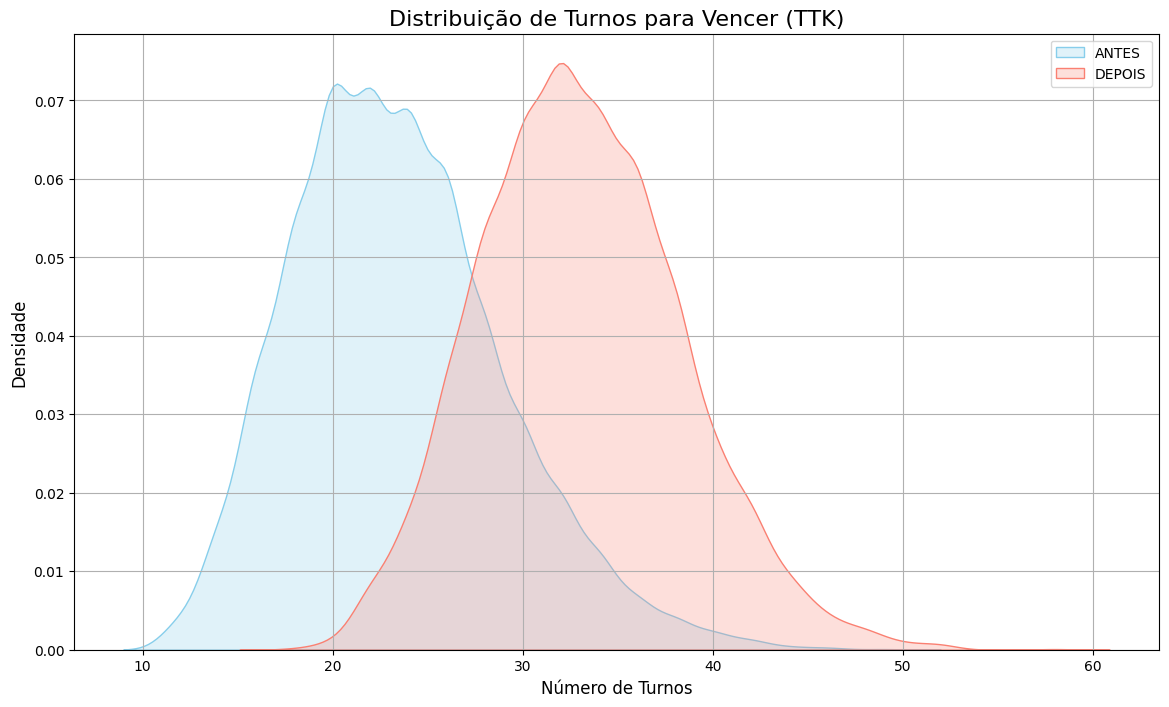

In [158]:
# Running the realistic simulations
n_simulations = 5000

# HP for combat simulation
BASE_ENTITY_HP = 200

# Loading skills for combat simulation
ENEMY_SKILLS = ['Quick Strike', 'Heavy Blow', 'Stone Shield', 'Wait']
ENEMY_EQUIPMENT = ['Celestial Blade', 'Dragonhide Armor', 'Crown of Omens']
AGENT_SKILLS_BEFORE  = ['Quick Strike', 'Heavy Blow', 'Stone Shield', 'Wait']
AGENT_SKILLS_AFTER =   ['Quick Strike', 'Heavy Blow', 'Stone Shield', 'Wait']
AGENT_EQUIPMENT_BEFORE  = ['Shortsword', 'Leather Tunic', 'Tome of Haste']
AGENT_EQUIPMENT_AFTER  = ['Blade of the Martyr', 'Bulwark of the Saint', 'Poisoner\'s Talisman']

# Simula o combate
results_before = [simulate_combat(BASE_ENTITY_HP, AGENT_EQUIPMENT_BEFORE, AGENT_SKILLS_BEFORE, ENEMY_EQUIPMENT, ENEMY_SKILLS) for _ in range(n_simulations)]
results_after = [simulate_combat(BASE_ENTITY_HP, AGENT_EQUIPMENT_AFTER, AGENT_SKILLS_AFTER, ENEMY_EQUIPMENT, ENEMY_SKILLS) for _ in range(n_simulations)]

# Processa os resultados
ttk_before = [r[0] for r in results_before]
wins_before = sum(1 for r in results_before if r[1] == 1)
win_rate_before = (wins_before / n_simulations) * 100

ttk_after = [r[0] for r in results_after]
wins_after = sum(1 for r in results_after if r[1] == 1)
win_rate_after = (wins_after / n_simulations) * 100

# Apresenta os resultados
print("\n--- RESULTADOS DA SIMULAÇÃO DE IMPACTO ---")
print(f"Cenário ANTES:")
print(f"  - Turnos Médios para Vencer: {np.mean(ttk_before):.2f} (Desvio Padrão: {np.std(ttk_before):.2f})")
print(f"  - Taxa de Vitória do Agente: {win_rate_before:.2f}%")

print(f"\nCenário DEPOIS:")
print(f"  - Turnos Médios para Vencer: {np.mean(ttk_after):.2f} (Desvio Padrão: {np.std(ttk_after):.2f})")
print(f"  - Taxa de Vitória do Agente: {win_rate_after:.2f}%")

# Visualização do TTK (permanece igual)
plt.figure(figsize=(14, 8))
sns.kdeplot(ttk_before, label='ANTES', color='skyblue', fill=True, warn_singular=False)
sns.kdeplot(ttk_after, label='DEPOIS', color='salmon', fill=True, warn_singular=False)
plt.title('Distribuição de Turnos para Vencer (TTK)', fontsize=16)
plt.xlabel('Número de Turnos', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()
